# Imports

In [92]:
import numpy as np
import cv2
import os 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from skimage.feature import greycomatrix, greycoprops 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [93]:
df  = pd.read_excel("data.xlsx")

In [94]:
df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1


In [95]:
df[df['N'] == 1]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
84,84,51,Female,84_left.jpg,84_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
191,191,51,Female,191_left.jpg,191_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
393,394,63,Male,394_left.jpg,394_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,3485,70,Male,3485_left.jpg,3485_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
3015,4149,55,Male,4149_left.jpg,4149_right.jpg,low image quality,low image quality,1,0,0,0,0,0,0,0
3147,4290,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0
3399,4571,51,Male,4571_left.jpg,4571_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0


In [96]:
df1  = df.loc[(df['N'] == 1) | (df["C"] ==1)| (df["D"] ==1)]

# Enviroment variables

In [97]:
df1.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0


In [98]:


# Images file names
file_names = []

# Loaded data
training_images = []
flags = []

# Features
grayscaled_images = []
inverted_images = []
thresholded_images = []
gray_histogram_of_images = []
RGB_histogram_of_images = []
conny_edged_images = []
laplacian_edged_images = []
x_edged_images = []
y_edged_images = []
Clahe_images = []

threshold_mean = []
threshold_median = []
threshold_std_dev = []

canny_mean = []
canny_median = []
canny_std_dev = []

# Filtering Cataract & Healthy eyes from others

In [99]:
classes={'Pre_Cataract - Copy':1,"Pre_Normal - Copy":0}

In [100]:

labels = []
file_names.clear()
labels.clear()

for name in classes:
    address=r'F:/PRIMI project/ODIR-5K/' +name
    
    for add in os.listdir(address):
            
            image = cv2.imread(address+'/'+add)
            image = cv2.resize(image, (224,224))
            image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype =cv2.CV_8U)
            file_names.append(image)
            labels.append(classes[name])
        
  





Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score.

The reason we do both of those things is because in the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model.

We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier).

Another way you can think about it is deep learning networks traditionally share many parameters - if you didn't scale your inputs in a way that resulted in similarly-ranged feature values (ie: over the whole dataset by subtracting mean) sharing wouldn't happen very easily because to one part of the image weight w is a lot and to another it's too small.

You will see in some CNN models that per-image whitening is used, which is more along the lines of your thinking.


In [101]:
print("Data Length =",len(file_names), "files", len(labels), "labels")

Data Length = 699 files 699 labels


# Cataract Ratio

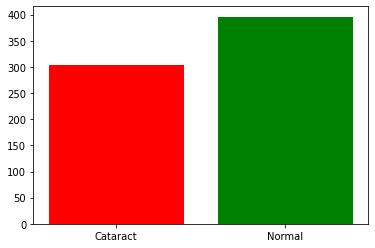

In [102]:
plt.bar([0,1], [len([i for i in labels if i == 1]), len([i for i in labels if i == 0])], color = ['r', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

# Loading Images

In [103]:
training_images=file_names

training_images = (np.array(training_images))

In [104]:
df2 = pd.DataFrame({'label':labels})
print (df2)

     label
0        1
1        1
2        1
3        1
4        1
..     ...
694      0
695      0
696      0
697      0
698      0

[699 rows x 1 columns]


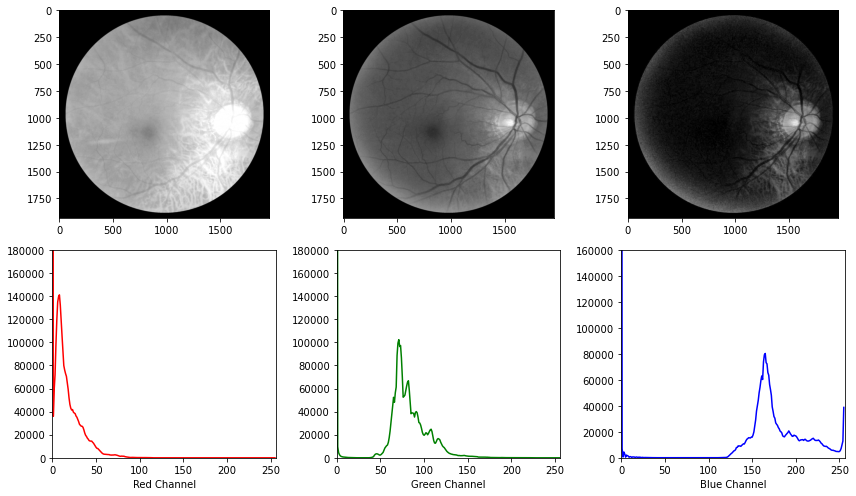

In [105]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('329_right.jpg')
image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
r,g,b = cv2.split(image) 

plt.figure(figsize=(12,7))  

plt.subplot(2,3,1)
plt.imshow(r,cmap = "gray")

    
plt.subplot(2,3,2)
plt.imshow(g,cmap = "gray")

    
plt.subplot(2,3,3)
plt.imshow(b,cmap = "gray")

        
plt.subplot(2,3,4)
hist = cv2.calcHist([b], [0], None, [256], [0, 256])
plt.plot(hist, color = "r")
plt.xlim([0, 256])
plt.ylim([0, 180000])
plt.xlabel('Red Channel')
    
        
plt.subplot(2,3,5)
hist = cv2.calcHist([g], [0], None, [256], [0, 256])
plt.plot(hist, color = "g")
plt.xlim([0, 256])
plt.ylim([0, 180000])
plt.xlabel('Green Channel')
    
plt.subplot(2,3,6)
hist = cv2.calcHist([r], [0], None, [256], [0, 256])
plt.plot(hist, color = "b")
plt.xlim([0, 256])
plt.ylim([0, 160000])
plt.xlabel('Blue Channel')
    


    
plt.tight_layout()


## Denoising

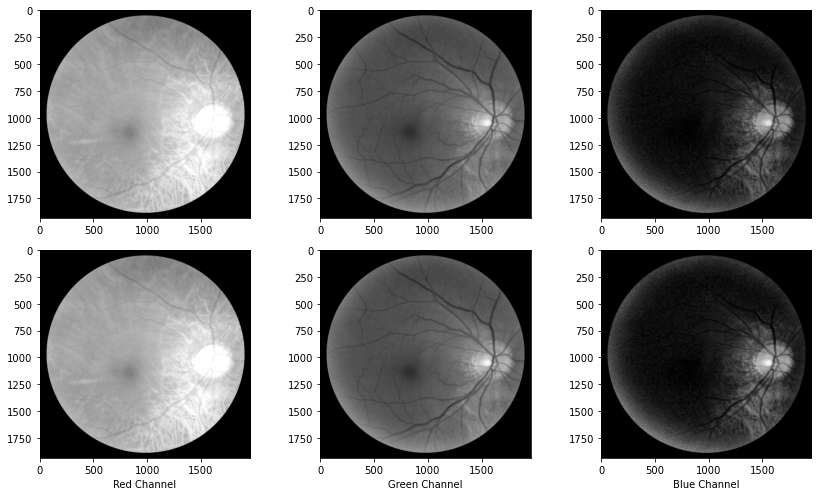

In [106]:
import numpy as np
img = cv2.imread('8_left.jpg')
median = cv2.medianBlur(img, 5)
# compare = np.concatenate((img, median), axis=1) #side by side comparison


plt.figure(figsize=(12,7))  

plt.subplot(2,3,1)
plt.imshow(r,cmap = "gray")
    
plt.subplot(2,3,2)
plt.imshow(g,cmap = "gray")

    
plt.subplot(2,3,3)
plt.imshow(b,cmap = "gray")

        
plt.subplot(2,3,4)
median = cv2.medianBlur(r, 5)
plt.imshow(median,cmap = "gray")
plt.xlabel('Red Channel')
    
        
plt.subplot(2,3,5)
median = cv2.medianBlur(g, 5)
plt.imshow(median,cmap = "gray")
plt.xlabel('Green Channel')
    
plt.subplot(2,3,6)
median = cv2.medianBlur(b, 5)
plt.imshow(median,cmap = "gray")
plt.xlabel('Blue Channel')
    


    
plt.tight_layout()

# Images Sample

In [107]:
def vis(images,operated_images,label):
    plt.figure(figsize=(12,7))    
    plt.subplot(2,4,1)
    plt.imshow( cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    plt.xlabel('Cataract')
    
    plt.subplot(2,4,2)
    plt.imshow(cv2.cvtColor(images[8], cv2.COLOR_BGR2RGB))
    plt.xlabel('Cataract')
    
    plt.subplot(2,4,3)
    plt.imshow(cv2.cvtColor(images[411], cv2.COLOR_BGR2RGB))
    plt.xlabel(' Normal ')
        
    plt.subplot(2,4,4)
    plt.imshow(cv2.cvtColor(images[621], cv2.COLOR_BGR2RGB))
    plt.xlabel(' Normal ')
    
        
    plt.subplot(2,4,5)
    plt.imshow( operated_images[0],cmap='gray')
    plt.xlabel(f'Cataract After {label}')
    
    plt.subplot(2,4,6)
    plt.imshow(operated_images[8],cmap='gray')
    plt.xlabel(f'Cataract After {label}')
    
    plt.subplot(2,4,7)
    plt.imshow(operated_images[411],cmap='gray')
    plt.xlabel(f'  Normal After {label}')
        
    plt.subplot(2,4,8)
    plt.imshow(operated_images[621],cmap='gray')
    plt.xlabel(f'  Normal After {label}')
        
    
    plt.tight_layout()

# Feature Extraction

##  Grayscaling

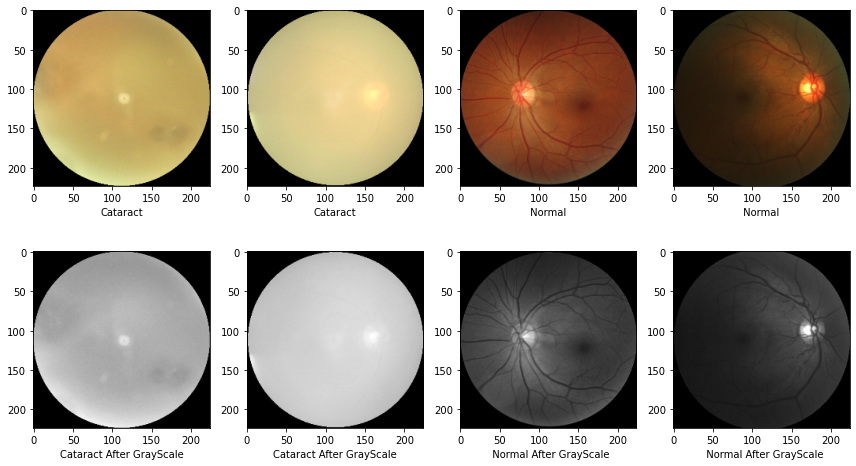

In [108]:
grayscaled_images.clear()
for idx, image in enumerate(training_images):
    r,g,b = cv2.split(image)
#     g= cv2.equalizeHist(g)
    gray_image = cv2.normalize(src=g, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    grayscaled_images.append(gray_image)

vis(training_images,grayscaled_images,'GrayScale')



## Histogram Equalization

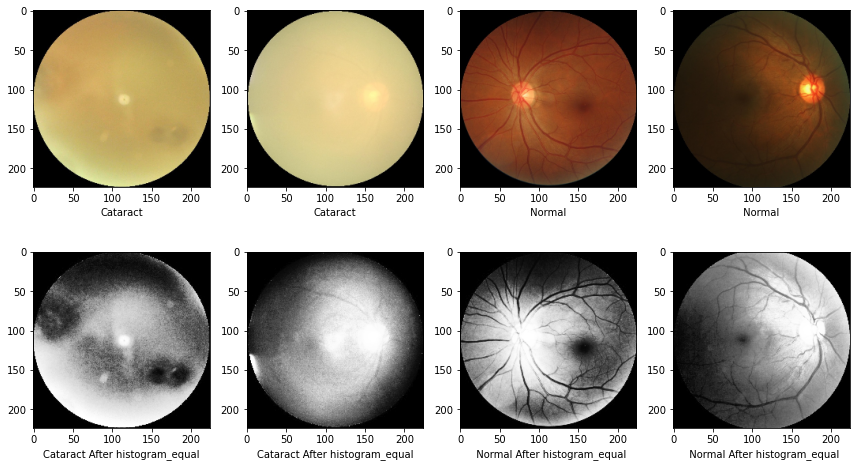

In [109]:
gray_histogram_of_images.clear()
for image in training_images:
    r,g,b = cv2.split(image)
    image_histogram = cv2.equalizeHist(g)
    gray_histogram_of_images.append(image_histogram)

vis(training_images,gray_histogram_of_images,'histogram_equal')

## CLAHE image

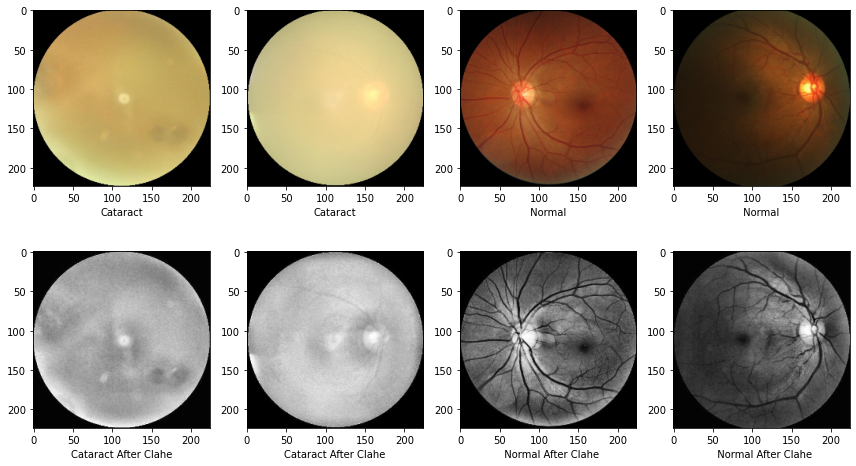

In [110]:
Clahe_images.clear()
num_white2 = []


for idx, image in enumerate(training_images):
    R, G, B = cv2.split(image)
    
    clahe = cv2.createCLAHE(clipLimit = 5)
    clahe_img = clahe.apply(G) 
    Clahe_images.append(clahe_img)
    W = np.sum(image == 255)
    B = np.sum(image == 0)
    num_white2.append((W*1000)/(W+B) )

vis(training_images,Clahe_images,'Clahe')
dfwh = pd.DataFrame({' num_white2': num_white2})

## Canny Edge detection

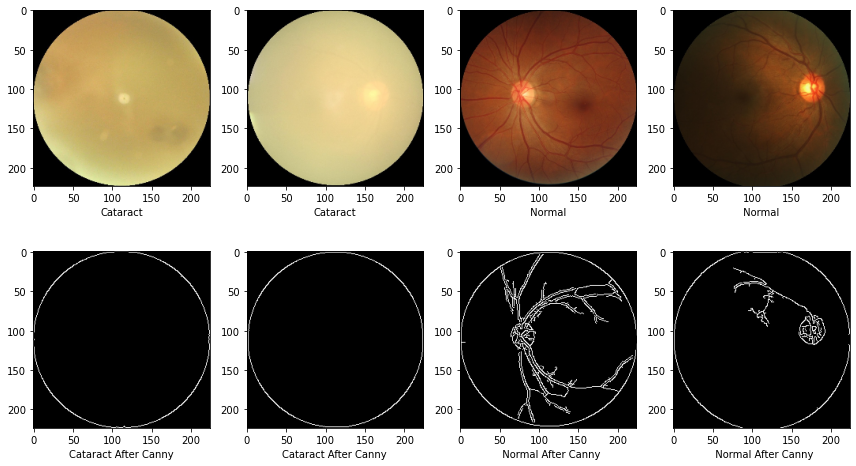

In [111]:
canny_edged_images = []
num_white = []


for image in training_images:
    image = cv2.Canny(image,30,200)
    canny_edged_images.append(image)
    W = np.sum(image == 255)
    B = np.sum(image == 0)
    num_white.append(W/(W+B) )
    
vis(training_images,canny_edged_images,'Canny')
dfwhite = pd.DataFrame({' num_white': num_white})


## Erosion

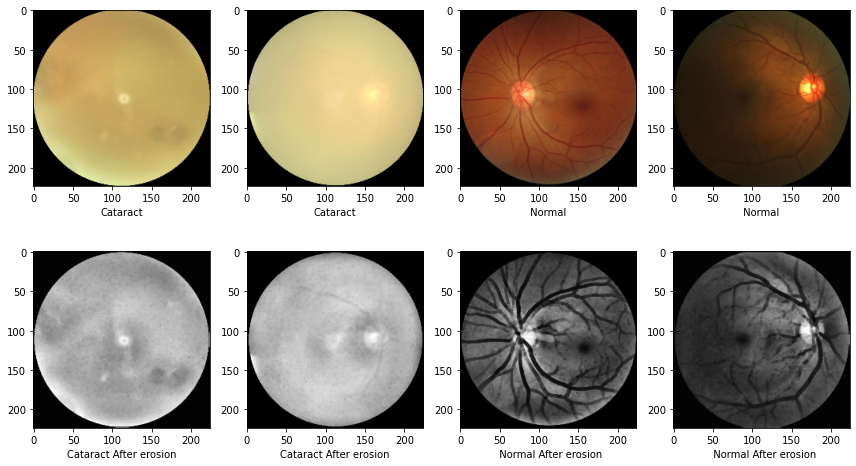

In [112]:
ero_images = []
ero_images.clear()
kernel = np.ones((3,3),np.uint8)
for idx, image in enumerate(Clahe_images):
    
    erosion = cv2.erode(image,kernel,iterations = 1)
    ero_images.append(erosion)

vis(training_images,ero_images,'erosion')

## Dilation

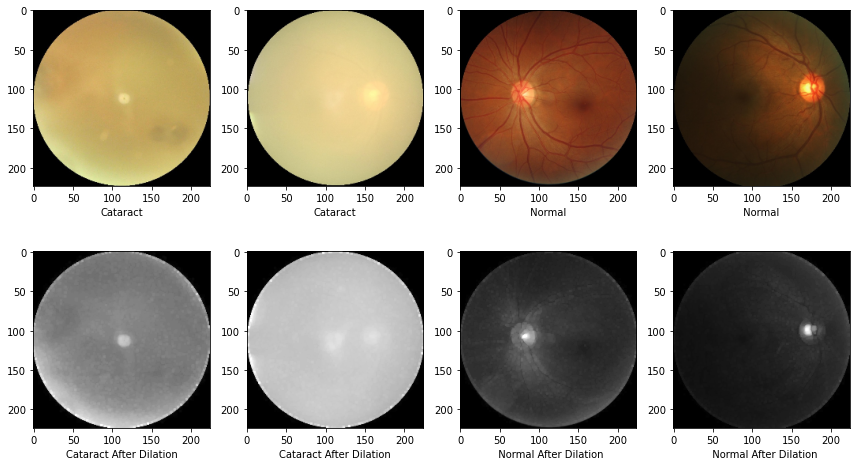

In [113]:
dil_images = []
dil_images.clear()
kernel = np.ones((3,3),np.uint8)
for idx, image in enumerate(training_images):
    R, G, B = cv2.split(image)
    
    dilation = cv2.dilate(R,kernel,iterations = 1)
    dil_images.append(dilation)

# showSamples(dil_images, True)
vis(training_images,dil_images,'Dilation')

In [114]:
dl_mean=[]
dl_median=[]
dl_std_dev=[]

for idx, image in enumerate(dil_images):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    dl_mean.append(mean)
    dl_median.append(median)
    dl_std_dev.append(std_dev)
    
dfdl = pd.DataFrame({'dl_mean':dl_mean})
dfdl_median = pd.DataFrame({'dl_std_dev':dl_median})
dfdl_std_dev = pd.DataFrame({'dl_std_dev':dl_std_dev})


## Green channel histeq

In [115]:

# i =  cv2.imread("C:/Users/Abhishek/Desktop/PRIMI project/ODIR-5K/Pre_Diabetic/211_right.jpg")
# i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
# r,g,b = cv2.split(i)
# r = cv2.dilate(r,kernel,iterations = 1)
# r = cv2.normalize(r, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
# plt.imshow(r,cmap = "gray")


## Bottom Hat

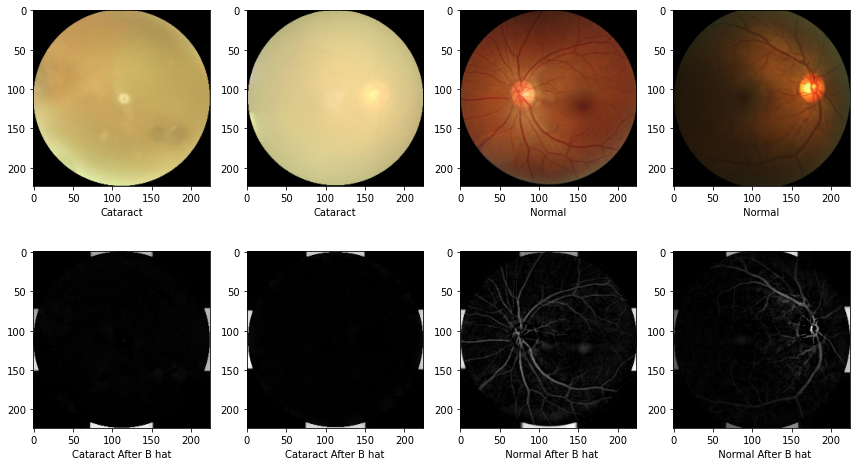

In [116]:
B_images = []
B_images.clear()
for idx, image in enumerate(training_images):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
#     blackhat = unsharp_mask(blackhat, radius=20, amount=5)
    B_images.append(blackhat)
vis(training_images, B_images,'B hat')

## Diabetes Detection


In [117]:
# from skimage import data
# from skimage.filters import unsharp_mask
# import matplotlib.pyplot as plt

# # image = B_images[788]
# i =  cv2.imread("C:/Users/Abhishek/Desktop/PRIMI project/ODIR-5K/Pre_Diabetic/211_right.jpg")
# i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
# r,g,b = cv2.split(i)
# rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
# g = cv2.morphologyEx(g, cv2.MORPH_BLACKHAT, rectKernel)
# # mean = np.mean(g)
# plt.imshow(g,cmap = "gray")

# result_1 = unsharp_mask(g, radius=1, amount=1)
# result_2 = unsharp_mask(g, radius=5, amount=2)
# result_3 = unsharp_mask(g, radius=10, amount=3)


# fig, axes = plt.subplots(nrows=2, ncols=2,
#                          sharex=True, sharey=True, figsize=(5, 5))
# ax = axes.ravel()

# ax[0].imshow(g, cmap=plt.cm.gray)
# ax[0].set_title('Original image')
# ax[1].imshow(result_1, cmap=plt.cm.gray)
# ax[1].set_title('Enhanced image, r=1, a=1')
# ax[2].imshow(result_2, cmap=plt.cm.gray)
# ax[2].set_title('Enhanced image, r=5, a=2')
# ax[3].imshow(result_3, cmap=plt.cm.gray)
# ax[3].set_title('Enhanced image, r=20, a=3')

# for a in ax:
#     a.axis('off')
# fig.tight_layout()
# plt.show()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [119]:
# from skimage import data
# from skimage.filters import unsharp_mask
# import matplotlib.pyplot as plt
# import cv2 
# import numpy as np

# # image = B_images[788]
# i =  cv2.imread("1146_left.jpg")
# i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
# r,g,b = cv2.split(i)
# kernel = np.ones((3,3),np.uint8)
# # rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
# # g = cv2.morphologyEx(r, cv2.MORPH_BLACKHAT, rectKernel)
# # mean = np.mean(g)
# r = cv2.dilate(r,kernel,iterations = 1)
# r = cv2.normalize(r, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
# plt.imshow(r,cmap = "gray")

# result_1 = unsharp_mask(r, radius=1, amount=1)
# result_2 = unsharp_mask(r, radius=5, amount=2)
# result_3 = unsharp_mask(r, radius=10, amount=3)


# fig, axes = plt.subplots(nrows=2, ncols=2,
#                          sharex=True, sharey=True, figsize=(10,10))
# ax = axes.ravel()

# ax[0].imshow(g, cmap=plt.cm.gray)
# ax[0].set_title('Original image')
# ax[1].imshow(result_1, cmap=plt.cm.gray)
# ax[1].set_title('Enhanced image, r=1, a=1')
# ax[2].imshow(result_2, cmap=plt.cm.gray)
# ax[2].set_title('Enhanced image, r=5, a=2')
# ax[3].imshow(result_3, cmap=plt.cm.gray)
# ax[3].set_title('Enhanced image, r=20, a=3')

# for a in ax:
#     a.axis('off')
# fig.tight_layout()
# plt.show()

**By using Bottom-hat transform, it is possible to
obtain details of the image as the edge, surface and size.
This process allows extracting the dark features..**

## Top hat

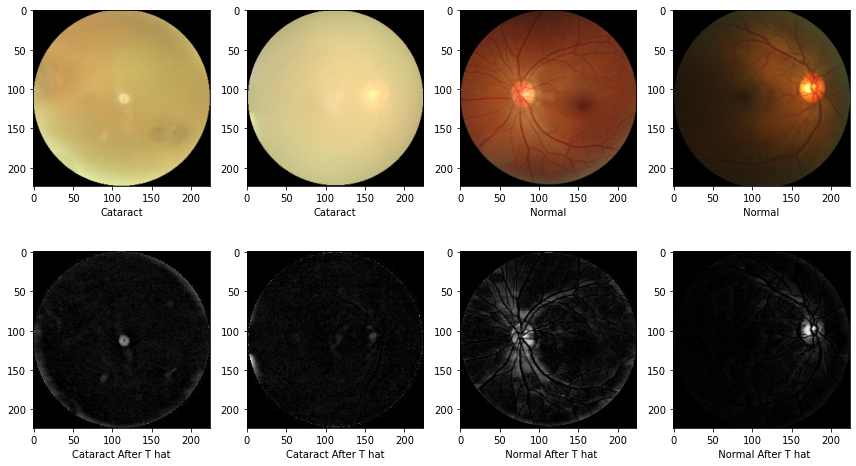

In [120]:
T_images = []
T_images.clear()
for idx, image in enumerate(training_images):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, rectKernel)
    tophat = cv2.cvtColor(tophat, cv2.COLOR_RGB2GRAY)
    
    T_images.append(tophat)
    
vis(training_images, T_images,'T hat')

In [121]:
T_images[1].shape

(224, 224)

**It is used for highlighting white object against dark background**

## GLCM

In [122]:
Energy = []
Correlation = []
Dissimilarity = []
Homogenity = []
Contrast = []


def energy(img):
          
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'energy')[0]

def correlation(img):
#           
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'correlation')[0]
    
def dissimilarity(img):

            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])      
            return  greycoprops(GLCM, 'dissimilarity')[0]
        
def homogenity(img):

            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return  greycoprops(GLCM, 'homogeneity')[0]
    
def contrast(img):

            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'contrast')[0]

        
for img in training_images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Energy.append(energy(img)[0])
    Correlation.append(correlation(img)[0])
    Dissimilarity.append(dissimilarity(img)[0])
    Homogenity.append(homogenity(img)[0])
    Contrast.append(contrast(img)[0])

    

dfe = pd.DataFrame({'Energy':Energy})
dfco = pd.DataFrame({'Correlation':Correlation})
dfd = pd.DataFrame({' Dissimilarity': Dissimilarity})
dfh = pd.DataFrame({'Homogenity':Homogenity})
dfc = pd.DataFrame({'Contrast':Contrast})


In [123]:

er_mean=[]
er_median=[]
er_std_dev=[]
for idx, image in enumerate(ero_images ):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    er_mean.append(mean)
    er_median.append(median)
    er_std_dev.append(std_dev)

dfer= pd.DataFrame({'er_mean':er_mean})
dfer_median= pd.DataFrame({'er_median':er_median})
dfer_std_dev = pd.DataFrame({'er_std_dev':er_std_dev})


In [124]:
clahe_mean=[]
clahe_median=[]
clahe_std_dev=[]

clahe_mean.clear()
clahe_median.clear()
clahe_std_dev.clear()

for image in Clahe_images:
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    clahe_mean.append(mean)
    clahe_median.append(median)
    clahe_std_dev.append(std_dev)
    
dfcl= pd.DataFrame({'clahe_mean':clahe_mean})
dfclahe_median= pd.DataFrame({'clahe_median':clahe_median})
dfclahe_std_dev = pd.DataFrame({'clahe_std_dev':clahe_std_dev})


In [125]:
canny_edged_images = []


for idx, image in enumerate(training_images):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    canny_mean.append(mean)
    canny_median.append(median)
    canny_std_dev.append(std_dev)

dfca= pd.DataFrame({'canny_mean':canny_mean})
dfconny_median= pd.DataFrame({'conny_median':canny_median})
dfconny_std_dev= pd.DataFrame({'canny_std_dev':canny_std_dev})


In [126]:
pdList = []
pdList = [dfwhite,dfer,dfd,dfh,dfer_median,dfer_std_dev,dfdl,dfdl_std_dev
          ,dfcl,
          dfwh,df2]  

new_df = pd.concat(pdList,axis=1)

In [ ]:
# pdList = [dfwhite,dfer,dfd,dfh,dfer_median,dfer_std_dev,dfdl,dfdl_std_dev
#           ,dfcl,dfwh,df2]  

# new_df = pd.concat(pdList,axis=1)

In [ ]:
# pdList = [dfe,dfc,dfd,dfco,dfh,df2]  
# new_df = pd.concat(pdList,axis=1)

In [ ]:
# pdList = [dfhi,dfhi_median,dfhi_std_dev,dfer,dfer_median,dfer_std_dev,dfdl,dfdl_std_dev,dfdl_median
#           ,dfcl,dfclahe_median,dfclahe_std_dev,dfth,dfthreshold_std_dev,
#           dfca,dfconny_std_dev,df2] 

# new_df = pd.concat(pdList,axis=1)

In [127]:
new_df.head(10)

,num_white,er_mean,Dissimilarity,Homogenity,er_median,er_std_dev,dl_mean,dl_std_dev,clahe_mean,num_white2,label
0,0.015944,124.510662,2.900985,0.531859,153.0,67.274746,83.985292,44.359298,134.271963,0.034417,1
1,0.015705,115.981087,2.683116,0.567100,140.0,66.326749,97.624462,51.751587,125.610272,0.327407,1
2,0.015944,135.971022,2.818666,0.558796,170.0,75.403161,127.480489,66.254486,146.166813,0.165071,1
3,0.016342,84.213429,1.713245,0.578155,91.0,54.362687,38.122190,31.398690,92.001016,0.033677,1
4,0.015705,87.002611,2.850937,0.473906,96.0,47.858605,44.415936,22.519694,101.258012,0.082095,1
5,0.017020,97.182159,2.456318,0.545777,117.0,55.879685,81.968371,43.040068,109.243224,0.230316,1
6,0.017738,97.566885,2.254024,0.576394,119.0,55.417219,70.915278,37.056832,108.588987,0.032965,1
7,0.015884,100.087492,1.983084,0.700834,91.0,76.242390,85.295679,76.823888,108.522222,187.358185,1
8,0.015685,139.740852,2.553752,0.617723,178.0,77.314319,113.011121,58.290342,148.956553,11.864131,1
9,0.015585,106.709224,1.919783,0.673083,132.0,58.043899,69.579082,36.454146,114.638393,0.033416,1


In [128]:
new_df.tail(10)

,num_white,er_mean,Dissimilarity,Homogenity,er_median,er_std_dev,dl_mean,dl_std_dev,clahe_mean,num_white2,label
689,0.091717,86.064832,5.610947,0.347296,91.0,57.819504,63.064613,36.755283,111.459861,0.308048,0
690,0.082470,88.020926,5.716488,0.338284,93.0,56.871761,59.331752,34.747976,114.055385,1.547858,0
691,0.065988,81.985591,4.124419,0.355468,90.0,44.182435,64.469109,31.317724,104.246672,0.048895,0
692,0.074777,79.972856,4.140395,0.356167,87.0,42.343320,64.287807,31.090362,101.694137,0.048750,0
693,0.096819,65.598832,3.176930,0.410567,66.0,45.648959,34.340362,23.960071,83.736787,7.635962,0
694,0.108658,67.256019,3.546785,0.394085,69.0,47.078322,37.382235,25.712914,87.232522,25.672330,0
695,0.047852,80.555983,3.372518,0.469070,85.0,55.845368,47.778520,32.197443,96.924207,1.554490,0
696,0.042969,72.412946,2.690123,0.480215,79.0,47.136165,37.506696,22.405288,88.135523,2.027204,0
697,0.071488,69.058195,3.096593,0.462437,75.0,45.950910,47.998844,27.292405,86.408681,0.098367,0
698,0.088229,72.385344,3.103419,0.451630,78.0,49.622136,44.491231,28.691375,90.290338,1.868546,0


<AxesSubplot:xlabel='Classes'>

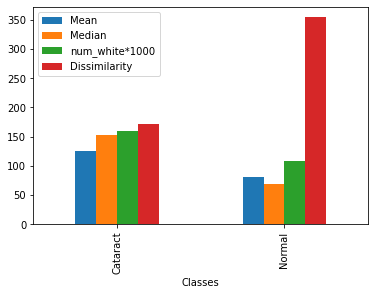

In [129]:
df = pd.DataFrame({
    'Classes': ["Cataract","Normal"],
    'Mean': [124.510662, 80.555983],
    'Median': [153.0, 69.0],
    "num_white*1000":[159.44,108.658],
    "Dissimilarity" :[171.3245 ,354.6785]
})
  
# plotting graph
df.plot(x="Classes", y=["Mean", "Median","num_white*1000","Dissimilarity"], kind="bar")

In [130]:
c = new_df.iloc[:, :-1]
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values

# Formating the data for Machine Learning

In [131]:

X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2, random_state=42)


stdSc = StandardScaler()
X_train = stdSc.fit_transform(X_train)
X_test = stdSc.fit_transform(X_test)

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')


X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [132]:
from collections import Counter

In [133]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.5813953488372093 Class 1:  0.4186046511627907
---------- Distribution of output variable in train data ----------
Class 0:  0.5071428571428571 Class 1:  0.4928571428571429


In [134]:
# print(training_features.shape)
print(X_train.shape)
print(y_train.shape)

(559, 10)
(559,)


In [135]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [136]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# LR = LogisticRegression(penalty= 'l2',random_state=0).fit(X_train, y_train)
# LR.fit(X_train, y_train)
# y_pred = LR.predict(X_test);
# LRaccuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
# print(LRaccuracy)

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>


Log loss on Test Data using Random Model 0.9110268975211402


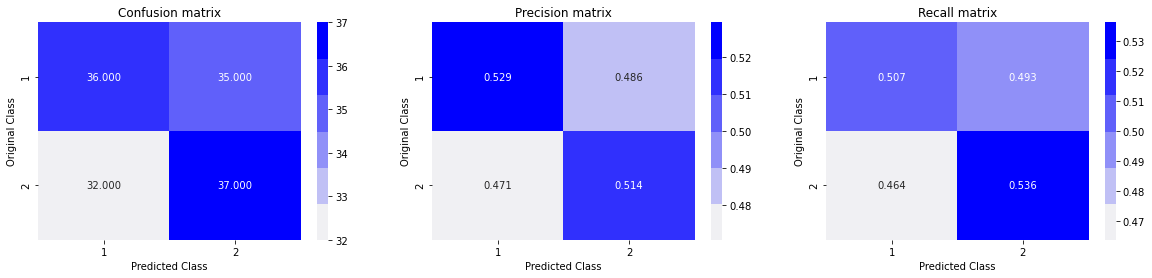

In [140]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.2048973567331479
For values of alpha =  0.0001 The log loss is: 0.2034973325244862
For values of alpha =  0.001 The log loss is: 0.2014201498514724
For values of alpha =  0.01 The log loss is: 0.21304676376946524
For values of alpha =  0.1 The log loss is: 0.2978707588474246
For values of alpha =  1 The log loss is: 0.40771673613271037
For values of alpha =  10 The log loss is: 0.45618132497882974


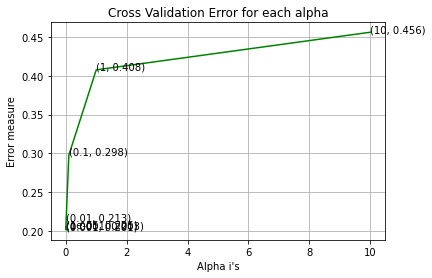

For values of best alpha =  0.001 The train log loss is: 0.16263374497773966
For values of best alpha =  0.001 The test log loss is: 0.2014201498514724
Total number of data points : 140


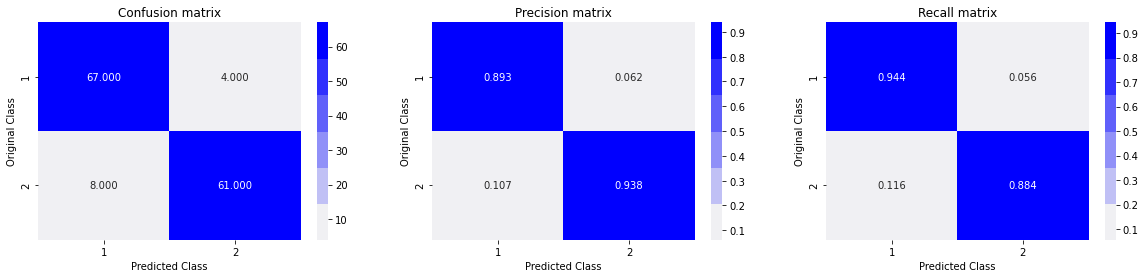

In [137]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.2056170759218395
For values of alpha =  0.0001 The log loss is: 0.22516022847789885
For values of alpha =  0.001 The log loss is: 0.21686062631558117
For values of alpha =  0.01 The log loss is: 0.22788302565333027
For values of alpha =  0.1 The log loss is: 0.2554168878266857
For values of alpha =  1 The log loss is: 0.7042017753149634
For values of alpha =  10 The log loss is: 0.7042017754675136


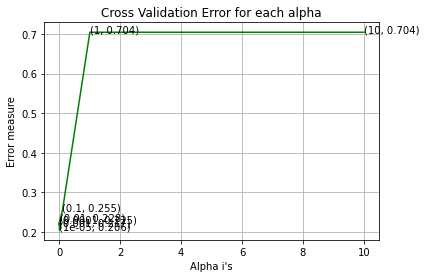

For values of best alpha =  1e-05 The train log loss is: 0.16582473071276135
For values of best alpha =  1e-05 The test log loss is: 0.2056170759218395
Total number of data points : 140


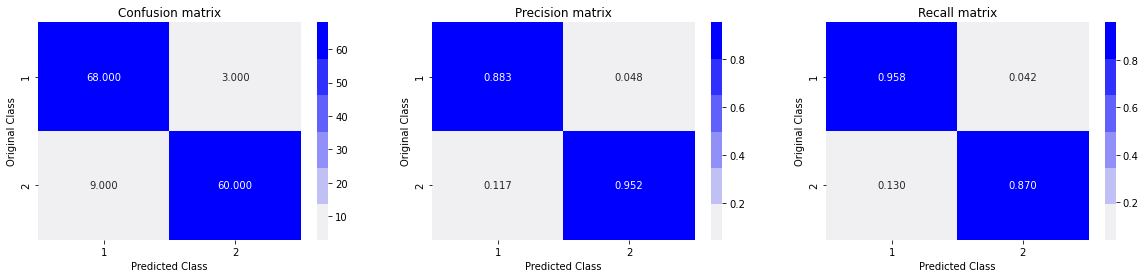

In [139]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Random Forest

For values of alpha =  64 The log loss is: 0.2056170759218395
For values of alpha =  80 The log loss is: 0.2056170759218395
For values of alpha =  100 The log loss is: 0.2056170759218395
For values of alpha =  128 The log loss is: 0.2056170759218395


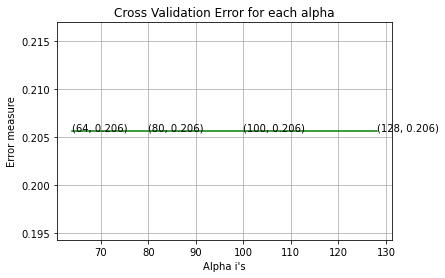

For values of best alpha =  64 The train log loss is: 0.06901440903665192
For values of best alpha =  64 The test log loss is: 0.23227802080845744
Total number of data points : 140


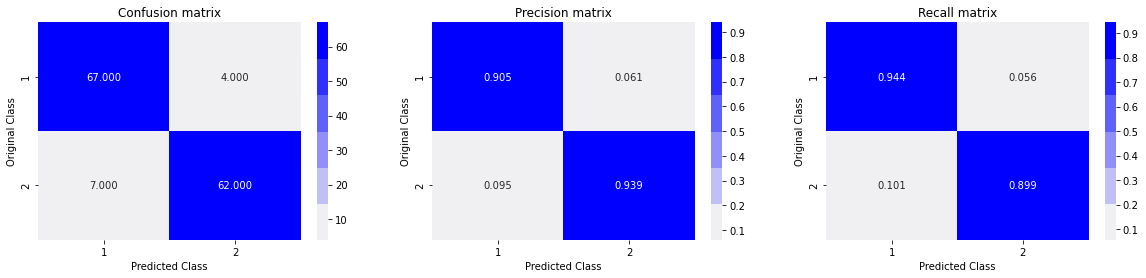

In [144]:
alpha = [64,80,100,128] # hyperparam for SGD classifier.

RF = RandomForestClassifier(max_depth=5,n_estimators=10 ,criterion='gini' , random_state=0)
RF.fit(X_train, y_train)
y_pred2 = RF.predict(X_test);
RFaccuracy = round(accuracy_score(y_test, y_pred2) * 100, 2)

log_error_array=[]
for i in alpha:
    RF = RandomForestClassifier(max_depth=5,n_estimators=i ,criterion='gini' , random_state=0)
    RF.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
RF = RandomForestClassifier(max_depth=5,n_estimators=alpha[best_alpha] ,criterion='gini' , random_state=0)
RF.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(RF, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [141]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67603	valid-logloss:0.68105
[10]	train-logloss:0.53568	valid-logloss:0.59620
[20]	train-logloss:0.43427	valid-logloss:0.53960
[30]	train-logloss:0.35858	valid-logloss:0.49980
[40]	train-logloss:0.29997	valid-logloss:0.46810
[50]	train-logloss:0.25398	valid-logloss:0.43112
[60]	train-logloss:0.21592	valid-logloss:0.40626
[70]	train-logloss:0.18575	valid-logloss:0.38011
[80]	train-logloss:0.16140	valid-logloss:0.35787
[90]	train-logloss:0.14125	valid-logloss:0.33678
[100]	train-logloss:0.12497	valid-logloss:0.31881
[110]	train-logloss:0.11137	valid-logloss:0.30882
[120]	train-logloss:0.10004	valid-logloss:0.30237
[130]	train-logloss:0.09059	valid-logloss:0.29736
[140]	train-logloss:0.08228	valid-logloss:0.29369
[150]	train-logloss:0.07534	valid-logloss:0.29254
[160]	train-logloss:0.06970	valid-logloss:0.28114
[170]	train-logloss:0.06456	valid-logloss:0.27404
[180]	train-logloss:0.06035	valid-logloss:0.26774
[190]	train-logloss:0.05666	valid-logloss:0.26211
[200]	train

Total number of data points : 140


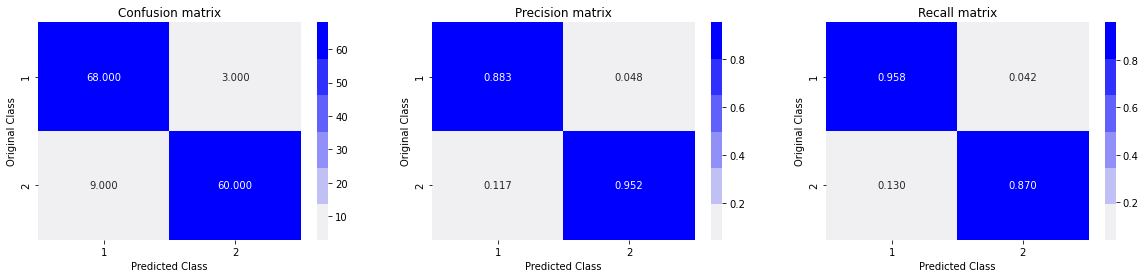

In [142]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [138]:
c.columns

Index([' num_white', 'er_mean', ' Dissimilarity', 'Homogenity', 'er_median',
       'er_std_dev', 'dl_mean', 'dl_std_dev', 'clahe_mean', ' num_white2'],
      dtype='object')

Test Accuracy Score of Basic Logistics Regression: 92.86


<AxesSubplot:>

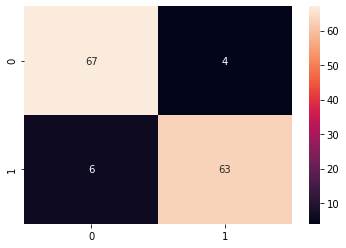

In [77]:
# from sklearn.linear_model import LogisticRegression
# import seaborn as sns

# model1 = LogisticRegression( penalty='l2',random_state=0)
# model1.fit(X_train,y_train)
# y_pred1 = model1.predict(X_test)
# test_accuracy1 = round(accuracy_score(y_test, y_pred1) * 100, 2)
# print('Test Accuracy Score of Basic Logistics Regression:',test_accuracy1)
# conf1 = confusion_matrix(y_test, y_pred1)
# sns.heatmap(conf1, annot=True)
# # print(classification_report(y_test,y_pred1))


![](http://)

In [78]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty= 'l2',random_state=0).fit(X_train, y_train)
LR.fit(X_train, y_train)
y_pred1 = LR.predict(X_test);
LR1accuracy = round(accuracy_score(y_test, y_pred1) * 100, 2)
print(LR1accuracy)

92.86


In [135]:
# from sklearn.linear_model import LogisticRegression
# model1 = LogisticRegression(random_state=0)
# model1.fit(X_train,y_train)
# y_pred1 = model1.predict(X_test)
# test_accuracy1 = round(accuracy_score(y_test, y_pred1) * 100, 2)
# print('Test Accuracy Score of Basic Logistics Regression:',test_accuracy1)
# conf1 = confusion_matrix(y_test, y_pred1)
# sns.heatmap(conf1, annot=True)
# print(classification_report(y_test,y_pred1))


In [49]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=5,n_estimators=10 ,criterion='gini' , random_state=0)
RF.fit(X_train, y_train)
y_pred2 = RF.predict(X_test);
RFaccuracy = round(accuracy_score(y_test, y_pred2) * 100, 2)
print(RFaccuracy)


84.29


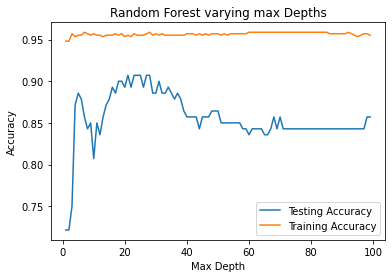

In [137]:
no_neighbors = np.arange(1, 100)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))
for i, k in enumerate(no_neighbors):

    knn = RandomForestClassifier(max_depth=3,n_estimators=k ,criterion='gini' , random_state=0)
    knn.fit(X_train,y_train)
   
    train_accuracy[i] = knn.score(X_train, y_train)

    test_accuracy[i] = knn.score(X_test, y_test)


plt.title('Random Forest varying max Depths')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [166]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier

For values of alpha =  1e-05 The log loss is: 0.2056170759218395
For values of alpha =  0.0001 The log loss is: 0.22516022847789885
For values of alpha =  0.001 The log loss is: 0.21686062631558117
For values of alpha =  0.01 The log loss is: 0.22788302565333027
For values of alpha =  0.1 The log loss is: 0.2554168878266857
For values of alpha =  1 The log loss is: 0.7042017753149634
For values of alpha =  10 The log loss is: 0.7042017754675136


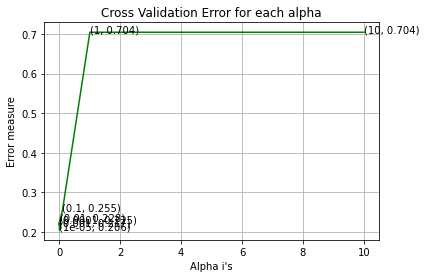

For values of best alpha =  1e-05 The train log loss is: 0.16582473071276135
For values of best alpha =  1e-05 The test log loss is: 0.2056170759218395
Total number of data points : 140


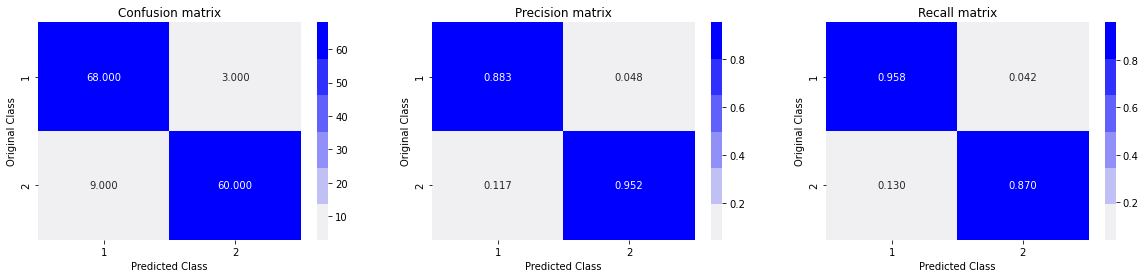

In [80]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [83]:
clf = SGDClassifier(alpha=1e-05, penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_test)


In [90]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67603	valid-logloss:0.68105
[10]	train-logloss:0.53568	valid-logloss:0.59620
[20]	train-logloss:0.43427	valid-logloss:0.53960
[30]	train-logloss:0.35858	valid-logloss:0.49980
[40]	train-logloss:0.29997	valid-logloss:0.46810
[50]	train-logloss:0.25398	valid-logloss:0.43112
[60]	train-logloss:0.21592	valid-logloss:0.40626
[70]	train-logloss:0.18575	valid-logloss:0.38011
[80]	train-logloss:0.16140	valid-logloss:0.35787
[90]	train-logloss:0.14125	valid-logloss:0.33678
[100]	train-logloss:0.12497	valid-logloss:0.31881
[110]	train-logloss:0.11137	valid-logloss:0.30882
[120]	train-logloss:0.10004	valid-logloss:0.30237
[130]	train-logloss:0.09059	valid-logloss:0.29736
[140]	train-logloss:0.08228	valid-logloss:0.29369
[150]	train-logloss:0.07534	valid-logloss:0.29254
[160]	train-logloss:0.06970	valid-logloss:0.28114
[170]	train-logloss:0.06456	valid-logloss:0.27404
[180]	train-logloss:0.06035	valid-logloss:0.26774
[190]	train-logloss:0.05666	valid-logloss:0.26211
[200]	train

Total number of data points : 140


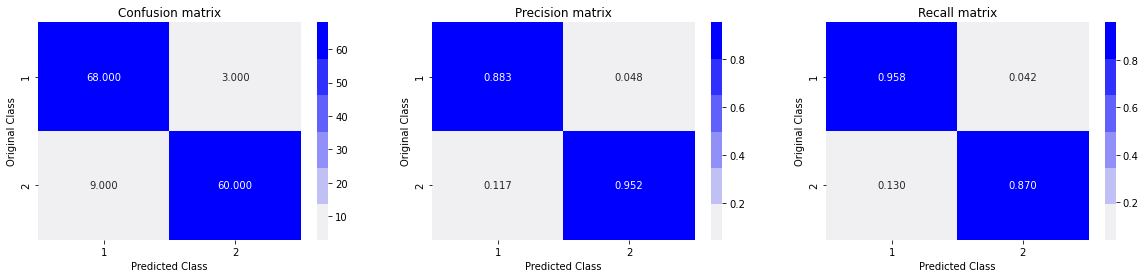

In [91]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Test Accuracy Score of Basic Logistics Regression: 92.86


<AxesSubplot:>

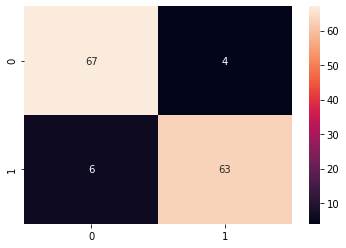

In [84]:
# from sklearn.linear_model import LogisticRegression
import seaborn as sns
RF = RandomForestClassifier(random_state=0)
RF.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)
test_accuracy1 = round(accuracy_score(y_test, y_pred1) * 100, 2)
print('Test Accuracy Score of Basic Logistics Regression:',test_accuracy1)
conf1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(conf1, annot=True)

In [52]:
y_pred2 = RF.predict(X_test);
RFaccuracy = round(accuracy_score(y_test, y_pred2) * 100, 2)
print(RFaccuracy)


92.14


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [63]:
from sklearn.metrics import log_loss

For values of alpha =  1e-05 The log loss is: 0.2056170759218395
For values of alpha =  0.0001 The log loss is: 0.22516022847789885
For values of alpha =  0.001 The log loss is: 0.21686062631558117
For values of alpha =  0.01 The log loss is: 0.22788302565333027
For values of alpha =  0.1 The log loss is: 0.2554168878266857
For values of alpha =  1 The log loss is: 0.7042017753149634
For values of alpha =  10 The log loss is: 0.7042017754675136


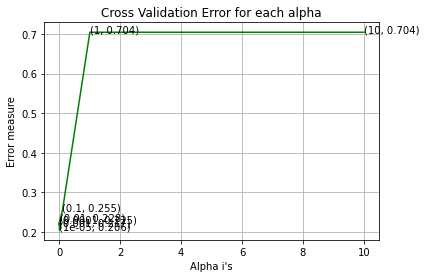

For values of best alpha =  1e-05 The train log loss is: 0.16582473071276135
For values of best alpha =  1e-05 The test log loss is: 0.2056170759218395
Total number of data points : 140


NameError: name 'plot_confusion_matrix' is not defined

In [64]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [70]:
from sklearn.svm import SVC
SV = SVC(C=5)
SV.fit(X_train, y_train)
y_pred3 = SV.predict(X_test);
SVaccuracy = round(accuracy_score(y_test, y_pred3) * 100, 2)
SVaccuracy

92.86

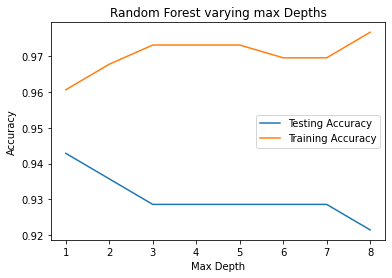

In [141]:
no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))
for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    knn = SVC(C=k)
    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Visualization of k values vs accuracy

plt.title('Random Forest varying max Depths')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [142]:
y_pred = SV.predict(X_test);
SVaccuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
SVaccuracy

94.29

In [143]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(max_depth= 3,random_state=0)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test);
DTaccuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
print(DTaccuracy)

87.86


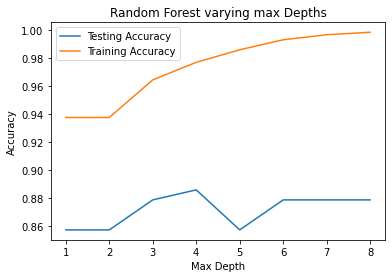

In [144]:
no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))
for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    knn = DecisionTreeClassifier(max_depth= k,random_state=0)
    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Visualization of k values vs accuracy

plt.title('Random Forest varying max Depths')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [145]:
y_pred = DT.predict(X_test1);
DTaccuracy = round(accuracy_score(y_test1, y_pred) * 100, 2)
print(DTaccuracy)

NameError: name 'X_test1' is not defined

In [146]:
from sklearn.neighbors import KNeighborsClassifier
NN = KNeighborsClassifier(n_neighbors=5,metric = "minkowski")
NN.fit(X_train,y_train)
y_pred = NN.predict(X_test);
NNaccuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
print(NNaccuracy)

89.29


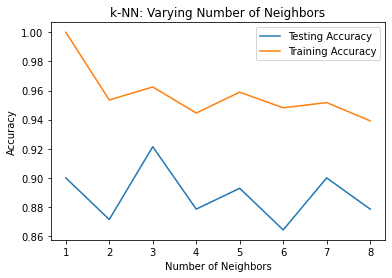

In [147]:
no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))
for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Visualization of k values vs accuracy

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [148]:
y_pred = NN.predict(X_test1);
NNaccuracy = round(accuracy_score(y_test1, y_pred) * 100, 2)
print(NNaccuracy)

NameError: name 'X_test1' is not defined

# Building, Training & Testing the NN Model

In [145]:
classifier = Sequential()

layer_info = Dense(activation='relu', input_dim=10, units=50)
classifier.add(layer_info)

# layer_info = Dense(activation='relu', units=6)
# classifier.add(layer_info)

# layer_info = Dense(activation='relu', units=30)
# classifier.add(layer_info)

layer_info = Dense(activation='sigmoid',units=1)
classifier.add(layer_info)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(X_train, y_train, batch_size=50, epochs=570)

flag_prediction = classifier.predict(X_test).round()

tn, fp, fn, tp = confusion_matrix(y_test, flag_prediction).ravel()

print("True Negative =",tn)
print("False Positive =",fp)
print("False Negative =",fn)
print("True Positive =",tp)


print(confusion_matrix(y_test, flag_prediction))
print(accuracy_score(y_test, flag_prediction)*100)

Epoch 1/570
12/12 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5921
Epoch 2/570
12/12 [==============================] - 0s 914us/step - loss: 0.5787 - accuracy: 0.8336
Epoch 3/570
12/12 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.8551
Epoch 4/570
12/12 [==============================] - 0s 1ms/step - loss: 0.4781 - accuracy: 0.8587
Epoch 5/570
12/12 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.8640
Epoch 6/570
12/12 [==============================] - 0s 917us/step - loss: 0.4242 - accuracy: 0.8623
Epoch 7/570
12/12 [==============================] - 0s 1ms/step - loss: 0.4043 - accuracy: 0.8676
Epoch 8/570
12/12 [==============================] - 0s 1ms/step - loss: 0.3858 - accuracy: 0.8658
Epoch 9/570
12/12 [==============================] - 0s 1ms/step - loss: 0.3691 - accuracy: 0.8712
Epoch 10/570
12/12 [==============================] - 0s 914us/step - loss: 0.3538 - accuracy: 0.8730
Epo

12/12 [==============================] - 0s 1ms/step - loss: 0.1146 - accuracy: 0.9624
Epoch 83/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.9589
Epoch 84/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1124 - accuracy: 0.9606
Epoch 85/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1121 - accuracy: 0.9571
Epoch 86/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1110 - accuracy: 0.9606
Epoch 87/570
12/12 [==============================] - 0s 997us/step - loss: 0.1107 - accuracy: 0.9606
Epoch 88/570
12/12 [==============================] - 0s 914us/step - loss: 0.1099 - accuracy: 0.9606
Epoch 89/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1093 - accuracy: 0.9624
Epoch 90/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1089 - accuracy: 0.9606
Epoch 91/570
12/12 [==============================] - 0s 1ms/step - loss: 0.1082 - accuracy: 0.9624
Epoch 92/

12/12 [==============================] - 0s 2ms/step - loss: 0.0814 - accuracy: 0.9714
Epoch 163/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0820 - accuracy: 0.9660
Epoch 164/570
12/12 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9660
Epoch 165/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0809 - accuracy: 0.9660
Epoch 166/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0813 - accuracy: 0.9714
Epoch 167/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0809 - accuracy: 0.9696
Epoch 168/570
12/12 [==============================] - 0s 748us/step - loss: 0.0807 - accuracy: 0.9678
Epoch 169/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9696
Epoch 170/570
12/12 [==============================] - 0s 997us/step - loss: 0.0794 - accuracy: 0.9714
Epoch 171/570
12/12 [==============================] - 0s 997us/step - loss: 0.0790 - accuracy: 0.969

12/12 [==============================] - 0s 748us/step - loss: 0.0640 - accuracy: 0.9767
Epoch 243/570
12/12 [==============================] - 0s 748us/step - loss: 0.0654 - accuracy: 0.9750
Epoch 244/570
12/12 [==============================] - 0s 748us/step - loss: 0.0644 - accuracy: 0.9732
Epoch 245/570
12/12 [==============================] - 0s 914us/step - loss: 0.0637 - accuracy: 0.9767
Epoch 246/570
12/12 [==============================] - 0s 914us/step - loss: 0.0636 - accuracy: 0.9767
Epoch 247/570
12/12 [==============================] - 0s 997us/step - loss: 0.0637 - accuracy: 0.9750
Epoch 248/570
12/12 [==============================] - 0s 998us/step - loss: 0.0636 - accuracy: 0.9750
Epoch 249/570
12/12 [==============================] - 0s 914us/step - loss: 0.0631 - accuracy: 0.9767
Epoch 250/570
12/12 [==============================] - 0s 997us/step - loss: 0.0647 - accuracy: 0.9732
Epoch 251/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0634 - acc

12/12 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9839
Epoch 323/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9839
Epoch 324/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.9821
Epoch 325/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9839
Epoch 326/570
12/12 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - 0s 1ms/step - loss: 0.0542 - accuracy: 0.9839
Epoch 327/570
12/12 [==============================] - 0s 914us/step - loss: 0.0545 - accuracy: 0.9821
Epoch 328/570
12/12 [==============================] - 0s 914us/step - loss: 0.0532 - accuracy: 0.9803
Epoch 329/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0551 - accuracy: 0.9803
Epoch 330/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0529 - accuracy: 0.9821
Epoch 331/570
12/12 [==============================] - 0s 1

12/12 [==============================] - 0s 914us/step - loss: 0.0461 - accuracy: 0.9839
Epoch 403/570
12/12 [==============================] - 0s 748us/step - loss: 0.0456 - accuracy: 0.9839
Epoch 404/570
12/12 [==============================] - 0s 665us/step - loss: 0.0458 - accuracy: 0.9857
Epoch 405/570
12/12 [==============================] - 0s 997us/step - loss: 0.0471 - accuracy: 0.9839
Epoch 406/570
12/12 [==============================] - 0s 914us/step - loss: 0.0459 - accuracy: 0.9857
Epoch 407/570
12/12 [==============================] - 0s 831us/step - loss: 0.0455 - accuracy: 0.9839
Epoch 408/570
12/12 [==============================] - 0s 997us/step - loss: 0.0456 - accuracy: 0.9839
Epoch 409/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 0.9839
Epoch 410/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9839
Epoch 411/570
12/12 [==============================] - 0s 997us/step - loss: 0.0451 - accur

12/12 [==============================] - 0s 914us/step - loss: 0.0403 - accuracy: 0.9857
Epoch 483/570
12/12 [==============================] - 0s 997us/step - loss: 0.0407 - accuracy: 0.9839
Epoch 484/570
12/12 [==============================] - 0s 997us/step - loss: 0.0400 - accuracy: 0.9857
Epoch 485/570
12/12 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9857
Epoch 486/570
12/12 [==============================] - 0s 748us/step - loss: 0.0395 - accuracy: 0.9857
Epoch 487/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0415 - accuracy: 0.9839
Epoch 488/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0399 - accuracy: 0.9875
Epoch 489/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0399 - accuracy: 0.9875
Epoch 490/570
12/12 [==============================] - 0s 997us/step - loss: 0.0403 - accuracy: 0.9875
Epoch 491/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0401 - accuracy: 0

12/12 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.9893
Epoch 563/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.9893
Epoch 564/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0344 - accuracy: 0.9875
Epoch 565/570
12/12 [==============================] - 0s 997us/step - loss: 0.0356 - accuracy: 0.9875
Epoch 566/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.9893
Epoch 567/570
12/12 [==============================] - 0s 1ms/step - loss: 0.0343 - accuracy: 0.9893
Epoch 568/570
12/12 [==============================] - 0s 832us/step - loss: 0.0353 - accuracy: 0.9893
Epoch 569/570
12/12 [==============================] - 0s 748us/step - loss: 0.0345 - accuracy: 0.9875
Epoch 570/570
12/12 [==============================] - 0s 997us/step - loss: 0.0351 - accuracy: 0.9857
True Negative = 69
False Positive = 2
False Negative = 8
True Positive = 61
[[69  2]
 [ 8 61]]
92